<h4>Name: Khor Yu Yang<br>Admin Number: 2123590

<h4>Name: Nevan Ang Kai Wen<br>Admin Number: 2122867<br>Class: DAAA/FT/2B/01

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import gym, gym.wrappers

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
import numpy as np


<h1>Reinforcement Learning

<h3>Implementation of Dueling Deep Q Learning

<h4>Baseline Model w/o Tuning/Improvements

In [ ]:
# Dueling DQN network
#! handles estimation of action function
class DuelingDeepQNetwork(tf.keras.Model):
    def __init__(self, n_actions, fc1_dims, fc2_dims):
        super(DuelingDeepQNetwork, self).__init__()
        self.dense1 = Dense(fc1_dims, activation='relu')
        self.dense2 = Dense(fc2_dims, activation='relu')
        self.V = Dense(1,activation=None) #value of state, returns raw value
        # Advantage Layer
        self.A = Dense(n_actions, activation=None)

    # Feed forward method
    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)

        # getting Q-value
        Q = (V + (A - tf.math.reduce_mean(A, axis=1, keepdims=True)))

        return Q

    # Advantage method for choosing actions
    def advantage(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        A = self.A(x)

        return A

# Replay Buffer
#! Stores/keep track of the experience of agent, stores memory of the state,reward...etc
class ReplayBuffer():
    def __init__(self, max_size, input_shape):
        # Max size of memory
        self.mem_size = max_size
        self.mem_counter = 0
        # State/New state/action/reward starting with 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
    
    # Store transitions
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_ # new state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_counter += 1 # increment counter

    # make sure agent learns from saved memory
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size)
        # sample batch of memory
        batch = np.random.choice(max_mem, batch_size, replace=False)

        # returning sample experience of that batch
        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones

Q-value is derived from the value and advantage, V & A layers return two separate outputs to the network

<h3>Agent 

The agent will consists of the memory (ReplayBuffer) and the dueling DQN network

In [ ]:
# Agent
#! Learn from experiences/transitions, update the model
class Agent():
    def __init__(self,lr, gamma, n_actions, epsilon, batch_size, input_dims, eps_decay=1e-3, eps_min=0.01,
    mem_size=100000, file_name='dueling_dqn.h5', fc1_dims=256,fc2_dims=256,replace=100):
        # action = 4
        self.action_space = [i for i in range(n_actions)]
        # discount factor
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_decay = eps_decay # epsilon decay
        self.eps_min = eps_min # min epsilon value to stop decay
        self.file_name = file_name
        self.batch_size = batch_size
        self.replace = replace
        self.learn_step_counter = 0
        # Memory
        self.memory = ReplayBuffer(mem_size, input_dims)
        self.q_eval = DuelingDeepQNetwork(n_actions, fc1_dims, fc2_dims)
        # Target Network with simialr architecture
        self.q_next = DuelingDeepQNetwork(n_actions, fc1_dims, fc2_dims)

        # Compile models
        self.q_eval.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        self.q_next.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    # # interface function between memory and agent
    # def store_transition(self, state, action, reward, new_state, done):
    #     self.memory.store_transition(state, action, reward, new_state, done)

    # # Function to choose action based on observations/environment
    # def choose_action(self, observation):
    #     # allow model to explore
    #     if np.random.random() < self.epsilon:
    #         action = np.random.choice(self.action_space)
    #     else:
    #         # greedy action
    #         state = np.array([observation])
    #         actions = self.q_eval.advantage(state)
    #         action = tf.math.argmax(actions, axis=1).numpy()[0] #select best action
        
    #     return action
    #  interface function between memory and agent
    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    # Function to choose action based on observations/environment
    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            # allow model to explore
            action = np.random.choice(self.action_space)
        else:
            # greedy action
            state = np.array([observation])
            actions = self.q_eval.advantage(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    # Learning function
    def learn(self):

        #! allow model to start learning only after memory is filled up, not 0s
        if self.memory.mem_counter < self.batch_size:
            return

        # Update target model weights
        if self.learn_step_counter % self.replace == 0:
            self.q_next.set_weights(self.q_eval.get_weights())

        states, actions, rewards, states_, dones = self.memory.sample_buffer(self.batch_size)
        # print(states)
        q_pred = self.q_eval(states)
        # print(states_)
        q_next = tf.math.reduce_max(self.q_next(states_), axis=1, keepdims=True).numpy()
        q_target = np.copy(q_pred)

        # improve on my solution!
        for idx, terminal in enumerate(dones):
            if terminal:
                q_next[idx] = 0.0
            # for action taken, is current reward + value of next step*gamma
            q_target[idx, actions[idx]] = rewards[idx] + self.gamma*q_next[idx]

        self.q_eval.train_on_batch(states, q_target)

        #decay epsilon unless it reaches min
        self.epsilon = self.epsilon - self.eps_decay if self.epsilon > self.eps_min else self.eps_min
        #when update parameters for target network
        self.learn_step_counter += 1

    # saving the model and loading the model
    def save_model(self):
        tf.keras.models.save_model(self.q_eval, 'baseline_network.h5')
        # self.q_eval.save_weights('baseline_network.h5')

    def load_model(self):
        self.q_eval = load_model(self.model_file)

<h3>Plot Learning Curve

In [ ]:
# function to plot learning curve
def plot_learning_curve(x, scores, epsilons, filename, lines=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, label='1')
    ax2 = fig.add_subplot(111, label='2', frame_on=False)

    ax.plot(x, epsilons, color='C0')
    ax.set_xlabel('Game', color='C0')
    ax.set_ylabel('Epsilon', color='C0')
    ax.tick_params(axis='x', color='C0')
    ax.tick_params(axis='y', color='C0')

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])
    ax2.scatter(x, running_avg, color='C1')
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color='C1')
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', color='C1')

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

In [ ]:
def moving_average(a, n=100) : #calculating the average of a certain number of data points over a fixed period of time.
    #average of a certain number of consecutive data points, and then sliding the window of data points over the entire dataset, 
    #updating the average as the window moves. 
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
def plot_scores(scores):
    scores_ma=moving_average(scores,n=100)
    plt.plot(np.arange(len(scores_ma)), scores_ma)
    plt.title('Tuned Model Learning Curve During Training')
    plt.ylabel('Score')
    plt.xlabel('Episode')
    plt.show()

<h3>Main Training Program

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-48-34f036171c81>:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecat

episode: 0/300, score: -174.73654058853174, average: -174.74, epsilon: 0.59
episode: 1/300, score: -95.75978389787673, average: -135.25, epsilon: 0.10
episode: 2/300, score: -52.48418266675166, average: -107.66, epsilon: 0.10
episode: 3/300, score: -172.78486320219056, average: -123.94, epsilon: 0.10
episode: 4/300, score: -40.89981039873855, average: -107.33, epsilon: 0.10
episode: 5/300, score: -85.89976568639574, average: -103.76, epsilon: 0.10
episode: 6/300, score: -563.8173277216665, average: -169.48, epsilon: 0.10
episode: 7/300, score: -113.40347463796765, average: -162.47, epsilon: 0.10
episode: 8/300, score: -134.43556632449324, average: -159.36, epsilon: 0.10
episode: 9/300, score: -142.52492800592927, average: -157.67, epsilon: 0.10
episode: 10/300, score: 43.212522073704406, average: -139.41, epsilon: 0.10
episode: 11/300, score: -33.07441073946127, average: -130.55, epsilon: 0.10
episode: 12/300, score: -68.9275075817647, average: -125.81, epsilon: 0.10
episode: 13/300, s

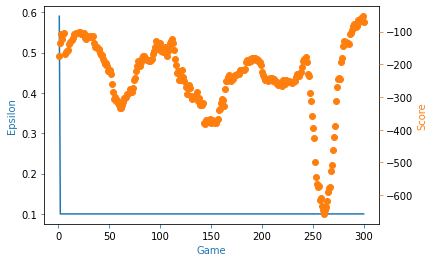

In [ ]:
# set environment
env = gym.make('LunarLander-v2')
n_episodes = 300
agent = Agent(gamma=0.99, epsilon=1, lr=0.01, input_dims=[8], eps_decay=0.01,mem_size=100000,
            batch_size=64,eps_min=0.1,fc1_dims=128,fc2_dims=128,replace=100,n_actions=4)

# define score and epsilon history
scores, eps_history = [], []

for i in range(n_episodes):
    done = False
    score = 0
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        observation = observation_
        agent.learn()

    eps_history.append(agent.epsilon)
    scores.append(score)

    avg_score = np.mean(scores[-100:])
    print("episode: {}/{}, score: {}, average: {:.2f}, epsilon: {:.2f}".format(
        i, n_episodes, score, avg_score, agent.epsilon))

file_name = 'BaseLine_LunarLander.png'
agent.q_eval.save_weights('baseline_network.h5')

# Show learning curves
x = [i+1 for i in range(n_episodes)]
plot_learning_curve(x, scores, eps_history, file_name) 

the model performance is not good, average reward at -369.75 after 300 episodes. It is not learning well. Since it is only the baseline model, we would want to modified it to make it perform better

<h3>Modify Model Network with additional hidden layer, more filters per layer to test its performance

In [ ]:
# Increase number of filters for Deuling DQN network
# Dueling DQN network
#! handles estimation of action function
class DuelingDeepQNetwork(tf.keras.Model):
    def __init__(self, n_actions, fc1_dims, fc2_dims, fc3_dims):
        super(DuelingDeepQNetwork, self).__init__()
        self.dense1 = Dense(fc1_dims, activation='relu')
        self.dense2 = Dense(fc2_dims, activation='relu')
        self.dense3 = Dense(fc3_dims, activation='relu')
        self.V = Dense(1,activation=None) #value of state, returns raw value
        # Advantage Layer
        self.A = Dense(n_actions, activation=None)

    # Feed forward method
    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        x = self.dense3(x)
        V = self.V(x)
        A = self.A(x)

        # getting Q-value
        Q = (V + (A - tf.math.reduce_mean(A, axis=1, keepdims=True)))

        return Q

    # Advantage method for choosing actions
    def advantage(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        x = self.dense3(x)
        A = self.A(x)

        return A

# Replay Buffer
#! Stores/keep track of the experience of agent, stores memory of the state,reward...etc
class ReplayBuffer():
    def __init__(self, max_size, input_shape):
        # Max size of memory
        self.mem_size = max_size
        self.mem_counter = 0
        # State/New state/action/reward starting with 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
    
    # Store transitions
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_ # new state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_counter += 1 # increment counter

    # make sure agent learns from saved memory
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size)
        # sample batch of memory
        batch = np.random.choice(max_mem, batch_size, replace=False)

        # returning sample experience of that batch
        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones

In [ ]:
# Agent
#! Learn from experiences/transitions, update the model
class Agent():
    def __init__(self,lr, gamma, n_actions, epsilon, batch_size, input_dims, eps_decay=1e-3, eps_min=0.01,
    mem_size=100000, file_name='dueling_dqn.h5', fc1_dims=256,fc2_dims=256,fc3_dims=256,replace=100):
        # action = 4
        self.action_space = [i for i in range(n_actions)]
        # discount factor
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_decay = eps_decay # epsilon decay
        self.eps_min = eps_min # min epsilon value to stop decay
        self.file_name = file_name
        self.batch_size = batch_size
        self.replace = replace
        self.learn_step_counter = 0
        # Memory
        self.memory = ReplayBuffer(mem_size, input_dims)
        self.q_eval = DuelingDeepQNetwork(n_actions, fc1_dims, fc2_dims,fc3_dims)
        # Target Network with simialr architecture
        self.q_next = DuelingDeepQNetwork(n_actions, fc1_dims, fc2_dims, fc3_dims)

        # Compile models
        self.q_eval.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        self.q_next.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    # # interface function between memory and agent
    # def store_transition(self, state, action, reward, new_state, done):
    #     self.memory.store_transition(state, action, reward, new_state, done)

    # # Function to choose action based on observations/environment
    # def choose_action(self, observation):
    #     # allow model to explore
    #     if np.random.random() < self.epsilon:
    #         action = np.random.choice(self.action_space)
    #     else:
    #         # greedy action
    #         state = np.array([observation])
    #         actions = self.q_eval.advantage(state)
    #         action = tf.math.argmax(actions, axis=1).numpy()[0] #select best action
        
    #     return action
    #  interface function between memory and agent
    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    # Function to choose action based on observations/environment
    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            # allow model to explore
            action = np.random.choice(self.action_space)
        else:
            # greedy action
            state = np.array([observation])
            actions = self.q_eval.advantage(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    # Learning function
    def learn(self):

        #! allow model to start learning only after memory is filled up, not 0s
        if self.memory.mem_counter < self.batch_size:
            return

        # Update target model weights
        if self.learn_step_counter % self.replace == 0:
            self.q_next.set_weights(self.q_eval.get_weights())

        states, actions, rewards, states_, dones = self.memory.sample_buffer(self.batch_size)
        # print(states)
        q_pred = self.q_eval(states)
        # print(states_)
        q_next = tf.math.reduce_max(self.q_next(states_), axis=1, keepdims=True).numpy()
        q_target = np.copy(q_pred)

        # improve on my solution!
        for idx, terminal in enumerate(dones):
            if terminal:
                q_next[idx] = 0.0
            # for action taken, is current reward + value of next step*gamma
            q_target[idx, actions[idx]] = rewards[idx] + self.gamma*q_next[idx]

        self.q_eval.train_on_batch(states, q_target)

        #decay epsilon unless it reaches min
        self.epsilon = self.epsilon - self.eps_decay if self.epsilon > self.eps_min else self.eps_min
        #when update parameters for target network
        self.learn_step_counter += 1

    # saving the model and loading the model
    def save_model(self, title='modified_network.h5'):
        self.q_eval.save(title)

    def load_model(self):
        self.q_eval = load_model(self.model_file)

<h3>Training Program

<ipython-input-52-426806dcdffc>:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


episode: 0/300, score: -153.8589525330272, average: -153.86, epsilon: 0.60
episode: 1/300, score: -212.36712710773378, average: -183.11, epsilon: 0.10
episode: 2/300, score: -195.76698282368045, average: -187.33, epsilon: 0.10
episode: 3/300, score: 236.7523234971918, average: -81.31, epsilon: 0.10
episode: 4/300, score: -64.3224318157409, average: -77.91, epsilon: 0.10
episode: 5/300, score: -346.1946942781202, average: -122.63, epsilon: 0.10
episode: 6/300, score: -46.206638493472994, average: -111.71, epsilon: 0.10
episode: 7/300, score: -167.85440545976542, average: -118.73, epsilon: 0.10
episode: 8/300, score: 21.171515897066456, average: -103.18, epsilon: 0.10
episode: 9/300, score: -135.3246942687135, average: -106.40, epsilon: 0.10
episode: 10/300, score: -85.40079552412637, average: -104.49, epsilon: 0.10
episode: 11/300, score: 140.30485099239326, average: -84.09, epsilon: 0.10
episode: 12/300, score: -212.16974580827176, average: -93.94, epsilon: 0.10
episode: 13/300, score:

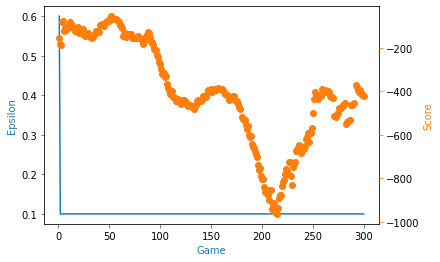

In [ ]:
# set environment
env = gym.make('LunarLander-v2')
n_episodes = 300
agent = Agent(gamma=0.99, epsilon=1, lr=0.01, input_dims=[8], eps_decay=0.01,mem_size=100000,
            batch_size=64,eps_min=0.1,fc1_dims=256,fc2_dims=256,fc3_dims=256,replace=100,n_actions=4)

# define score and epsilon history
scores, eps_history = [], []

for i in range(n_episodes):
    done = False
    score = 0
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        observation = observation_
        agent.learn()

    eps_history.append(agent.epsilon)
    scores.append(score)

    avg_score = np.mean(scores[-100:])
    print("episode: {}/{}, score: {}, average: {:.2f}, epsilon: {:.2f}".format(
        i, n_episodes, score, avg_score, agent.epsilon))

file_name = 'modfiied_LunarLander.png'
agent.q_eval.save_weights('modified_network.h5')

# Show learning curves
x = [i+1 for i in range(n_episodes)]
plot_learning_curve(x, scores, eps_history, file_name) 

The result shown that the average reward got worser with increasing layers and filter. Therefore, we reduced it back to the original layers and tune its hyperparameters

<h3>Model After Hyperparameter tuning

In [ ]:
# Dueling DQN network
#! handles estimation of action function
class DuelingDeepQNetwork(tf.keras.Model):
    def __init__(self, n_actions, fc1_dims, fc2_dims):
        super(DuelingDeepQNetwork, self).__init__()
        self.dense1 = Dense(fc1_dims, activation='relu')
        self.dense2 = Dense(fc2_dims, activation='relu')
        self.V = Dense(1,activation=None) #value of state, returns raw value
        # Advantage Layer
        self.A = Dense(n_actions, activation=None)

    # Feed forward method
    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)

        # getting Q-value
        Q = (V + (A - tf.math.reduce_mean(A, axis=1, keepdims=True)))

        return Q

    # Advantage method for choosing actions
    def advantage(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        A = self.A(x)

        return A

# Replay Buffer
#! Stores/keep track of the experience of agent, stores memory of the state,reward...etc
class ReplayBuffer():
    def __init__(self, max_size, input_shape):
        # Max size of memory
        self.mem_size = max_size
        self.mem_counter = 0
        # State/New state/action/reward starting with 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
    
    # Store transitions
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_ # new state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_counter += 1 # increment counter

    # make sure agent learns from saved memory
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size)
        # sample batch of memory
        batch = np.random.choice(max_mem, batch_size, replace=False)

        # returning sample experience of that batch
        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones

In [ ]:
# Agent
#! Learn from experiences/transitions, update the model
class Agent():
    def __init__(self,lr, gamma, n_actions, epsilon, batch_size, input_dims, eps_decay=1e-3, eps_min=0.01,
    mem_size=100000, file_name='dueling_dqn.h5', fc1_dims=256,fc2_dims=256,replace=100):
        # action = 4
        self.action_space = [i for i in range(n_actions)]
        # discount factor
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_decay = eps_decay # epsilon decay
        self.eps_min = eps_min # min epsilon value to stop decay
        self.file_name = file_name
        self.batch_size = batch_size
        self.replace = replace
        self.learn_step_counter = 0
        # Memory
        self.memory = ReplayBuffer(mem_size, input_dims)
        self.q_eval = DuelingDeepQNetwork(n_actions, fc1_dims, fc2_dims)
        # Target Network with simialr architecture
        self.q_next = DuelingDeepQNetwork(n_actions, fc1_dims, fc2_dims)

        # Compile models
        self.q_eval.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        self.q_next.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    # # interface function between memory and agent
    # def store_transition(self, state, action, reward, new_state, done):
    #     self.memory.store_transition(state, action, reward, new_state, done)

    # # Function to choose action based on observations/environment
    # def choose_action(self, observation):
    #     # allow model to explore
    #     if np.random.random() < self.epsilon:
    #         action = np.random.choice(self.action_space)
    #     else:
    #         # greedy action
    #         state = np.array([observation])
    #         actions = self.q_eval.advantage(state)
    #         action = tf.math.argmax(actions, axis=1).numpy()[0] #select best action
        
    #     return action
    #  interface function between memory and agent
    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    # Function to choose action based on observations/environment
    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            # allow model to explore
            action = np.random.choice(self.action_space)
        else:
            # greedy action
            state = np.array([observation])
            actions = self.q_eval.advantage(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    # Learning function
    def learn(self):

        #! allow model to start learning only after memory is filled up, not 0s
        if self.memory.mem_counter < self.batch_size:
            return

        # Update target model weights
        if self.learn_step_counter % self.replace == 0:
            self.q_next.set_weights(self.q_eval.get_weights())

        states, actions, rewards, states_, dones = self.memory.sample_buffer(self.batch_size)
        # print(states)
        q_pred = self.q_eval(states)
        # print(states_)
        q_next = tf.math.reduce_max(self.q_next(states_), axis=1, keepdims=True).numpy()
        q_target = np.copy(q_pred)

        # improve on my solution!
        for idx, terminal in enumerate(dones):
            if terminal:
                q_next[idx] = 0.0
            # for action taken, is current reward + value of next step*gamma
            q_target[idx, actions[idx]] = rewards[idx] + self.gamma*q_next[idx]

        self.q_eval.train_on_batch(states, q_target)

        #decay epsilon unless it reaches min
        self.epsilon = self.epsilon - self.eps_decay if self.epsilon > self.eps_min else self.eps_min
        #when update parameters for target network
        self.learn_step_counter += 1

    # saving the model and loading the model
    def save_model(self):
        tf.keras.models.save_model(self.q_eval, 'baseline_network.h5')
        # self.q_eval.save_weights('baseline_network.h5')

    def load_model(self):
        self.q_eval = load_model(self.model_file)

<ipython-input-6-34f036171c81>:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


episode: 0/300, score: -119.34619507340157, average: -119.35, epsilon: 0.99
episode: 1/300, score: -202.83045970231504, average: -161.09, epsilon: 0.91
episode: 2/300, score: -83.01359579346148, average: -135.06, epsilon: 0.84
episode: 3/300, score: -240.2683956066092, average: -161.36, epsilon: 0.69
episode: 4/300, score: -188.10924172751072, average: -166.71, epsilon: 0.56
episode: 5/300, score: -45.47616371298651, average: -146.51, epsilon: 0.40
episode: 6/300, score: -302.0308910944513, average: -168.72, epsilon: 0.18
episode: 7/300, score: -4.186305822113638, average: -148.16, epsilon: 0.01
episode: 8/300, score: -118.35904133600434, average: -144.85, epsilon: 0.01
episode: 9/300, score: -159.26095957891658, average: -146.29, epsilon: 0.01
episode: 10/300, score: 193.65771612848636, average: -115.38, epsilon: 0.01
episode: 11/300, score: -71.920491554189, average: -111.76, epsilon: 0.01
episode: 12/300, score: -59.412269461093224, average: -107.74, epsilon: 0.01
episode: 13/300, s

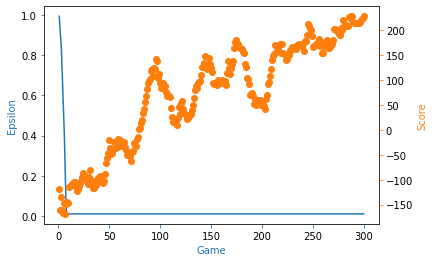

In [ ]:
# set environment
env = gym.make('LunarLander-v2')
n_episodes = 300
# Tuned hyperparameters
agent = Agent(gamma=0.99, epsilon=1, lr=0.001, input_dims=[8], eps_decay=0.001,mem_size=100000,
            batch_size=64,eps_min=0.01,fc1_dims=128,fc2_dims=128,replace=100,n_actions=4)

# define score and epsilon history
scores, eps_history = [], []

for i in range(n_episodes):
    done = False
    score = 0
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        observation = observation_
        agent.learn()

    eps_history.append(agent.epsilon)
    scores.append(score)

    avg_score = np.mean(scores[-100:])
    print("episode: {}/{}, score: {}, average: {:.2f}, epsilon: {:.2f}".format(
        i, n_episodes, score, avg_score, agent.epsilon))

file_name = 'tuned_LunarLander.png'
agent.q_eval.save_weights('tuned_network.h5')

# Show learning curves
x = [i+1 for i in range(n_episodes)]
plot_learning_curve(x, scores, eps_history, file_name) 

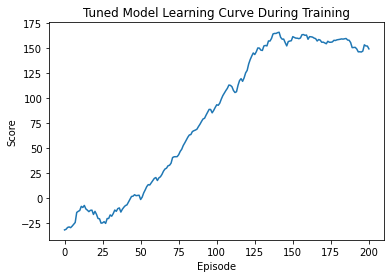

In [ ]:
#Tuned Model
plot_scores(scores)

Both learning curves shows a consistency in the scores/rewards increasing every episodes

<h3>Testing of Model with the tuned parameters model

In [ ]:
import cv2

In [ ]:
# Agent
#! Learn from experiences/transitions, update the model
class Agent():
    def __init__(self,lr, gamma, n_actions, epsilon, batch_size, input_dims, eps_decay=1e-3, eps_min=0.01,
    mem_size=100000, file_name='dueling_dqn.h5',replace=100):
        # action = 4
        self.action_space = [i for i in range(n_actions)]
        # discount factor
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_decay = eps_decay # epsilon decay
        self.eps_min = eps_min # min epsilon value to stop decay
        self.file_name = file_name
        self.batch_size = batch_size
        self.replace = replace
        self.learn_step_counter = 0
        # Memory
        self.memory = ReplayBuffer(mem_size, input_dims)
        self.q_eval = DuelingDeepQNetwork(n_actions, fc1_dims=128, fc2_dims=128)
        # Target Network with simialr architecture
        self.q_next = DuelingDeepQNetwork(n_actions, fc1_dims=128, fc2_dims=128)

        # Compile models
        self.q_eval.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        self.q_next.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    # # interface function between memory and agent
    # def store_transition(self, state, action, reward, new_state, done):
    #     self.memory.store_transition(state, action, reward, new_state, done)

    # # Function to choose action based on observations/environment
    # def choose_action(self, observation):
    #     # allow model to explore
    #     if np.random.random() < self.epsilon:
    #         action = np.random.choice(self.action_space)
    #     else:
    #         # greedy action
    #         state = np.array([observation])
    #         actions = self.q_eval.advantage(state)
    #         action = tf.math.argmax(actions, axis=1).numpy()[0] #select best action
        
    #     return action
    #  interface function between memory and agent
    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    # Function to choose action based on observations/environment
    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            # allow model to explore
            action = np.random.choice(self.action_space)
        else:
            # greedy action
            state = np.array([observation])
            actions = self.q_eval.advantage(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    # Learning function
    def learn(self):

        #! allow model to start learning only after memory is filled up, not 0s
        if self.memory.mem_counter < self.batch_size:
            return

        # Update target model weights
        if self.learn_step_counter % self.replace == 0:
            self.q_next.set_weights(self.q_eval.get_weights())

        states, actions, rewards, states_, dones = self.memory.sample_buffer(self.batch_size)
        # print(states)
        q_pred = self.q_eval(states)
        # print(states_)
        q_next = tf.math.reduce_max(self.q_next(states_), axis=1, keepdims=True).numpy()
        q_target = np.copy(q_pred)

        # improve on my solution!
        for idx, terminal in enumerate(dones):
            if terminal:
                q_next[idx] = 0.0
            # for action taken, is current reward + value of next step*gamma
            q_target[idx, actions[idx]] = rewards[idx] + self.gamma*q_next[idx]

        self.q_eval.train_on_batch(states, q_target)

        #decay epsilon unless it reaches min
        self.epsilon = self.epsilon - self.eps_decay if self.epsilon > self.eps_min else self.eps_min
        #when update parameters for target network
        self.learn_step_counter += 1

    # saving the model and loading the model
    def save_model(self):
        tf.keras.models.save_model(self.q_eval, 'baseline_network.h5')
        # self.q_eval.save_weights('baseline_network.h5')

    def load_model(self):
        self.q_eval = load_model(self.model_file)


    #Test the network function
    def test_agent(self, env, episodes = 100):
        self.q_eval = DuelingDeepQNetwork(4, fc1_dims=128, fc2_dims=128)
        self.q_eval.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        self.q_eval.build(input_shape=(1, 8))
        self.q_eval.load_weights('tuned_network.h5')
        total_reward = 0
        counter = 0
        scores = []
        goal = 200
        # Loop through the specified number of episodes
        for episode in range(episodes):
            state = env.reset()
            state = state[0]
            episode_reward = 0
            goal = 200
            done = False

            # Run one episode
            while not done:
                # Choose an action based on the state
                action = self.choose_action(state)
                
                # Take the action in the environment and observe the next state, reward, and done flag
                next_state, reward, done, truncated, _ = env.step(action)
                state = next_state
                # Update the total reward for this episode
                episode_reward += reward
                
            scores.append(episode_reward)
            
            # Update the total reward and success rate
            total_reward += episode_reward
            
        # Close the environment
        # Compute the average reward and success rate
        avg_reward = total_reward / episodes
        # success_rate = success / episodes
        
        return avg_reward, scores

In [ ]:
from gym.wrappers.record_video import RecordVideo

# set environment
env = gym.make('LunarLander-v2')
env = gym.wrappers.RecordVideo(env, './VideoRecordLunar', episode_trigger = lambda x: x % 10 == 0)

# Tuned hyperparameters, reuse the agent class with tuned parameters
agent = Agent(gamma=0.99, epsilon=0, lr=0.001, input_dims=[8], eps_decay=0.001,mem_size=100000,
            batch_size=64,eps_min=0.01,replace=100,n_actions=4)
# agent.load_weights('./dueling/tuned_network.h5')
# Test the agent
avg_reward, scores = agent.test_agent(env)

print(scores)
print('Average reward:', avg_reward)
#Tuned Model
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

<ipython-input-6-34f036171c81>:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/

ValueError: ignored

<h3>References:<br><h5>https://www.youtube.com/watch?v=CoePrz751lg